In [1]:
import numpy as np
import xarray as xr
from netCDF4 import Dataset
import matplotlib.pyplot as plt
from pyproj import CRS
import wrf
import cartopy.crs as ccrs
import regionmask
import geopandas as gp
from os import path
import pickle
import matplotlib.patches as patches
import matplotlib.patches as mpatches
import cartopy.io.shapereader as shpreader
import matplotlib.patheffects as PathEffects
from matplotlib import colormaps
from matplotlib import colors
import sys  
sys.path.insert(1, 'functions_programs/')
import functions
from shapely import geometry
import pandas as pd

# inputs

In [2]:
file_coords = "/data/keeling/a/erickkc2/scratch/WRF-WVT_AMZ2/03_WRF-WVT_CPM/wrfout_from_derecho/wrfout_d01_2018-05-01_00:00:00"
file_shp = "/data/keeling/a/erickkc2/scratch/shp_regions5/amazon_basin.shp"
shp_field = "ID"
path_out = "/data/keeling/a/erickkc2/scratch/2LDRM_AMZ2/01_inputs/CPM/"

fileout_dat = "WRF_amazon.dat"
fileout_pkl = "WRF_amazon.pkl"
# # path_plots = ""
coarse_factor = 1

# # study region limit
# # only for plotting
# lon_min = -68
# lon_max = -60
# lat_min = -35
# lat_max = -25

# # for plotting: labeling coords
# xcentroid_field = "x_label"
# ycentroid_field = "y_label"

# # ID of regions that are ocean
# regions_ocean = [8]
# regions_noregion =[]

# # rotate colors
# rot_colors = 4
# colormap_name = "Spectral"
# color_ocean = "lightskyblue"
# start_colormap = 0
# end_colormap = 1

# PROCESS

In [3]:
xda_coords = xr.open_dataset(file_coords)["P"]
xda_coords = xda_coords[0,0,...]
xda_coords = xda_coords.drop_vars("XTIME")

if (coarse_factor >= 1):
    xda_coords = xda_coords.coarsen(south_north = coarse_factor, west_east = coarse_factor, boundary='trim').mean()
    

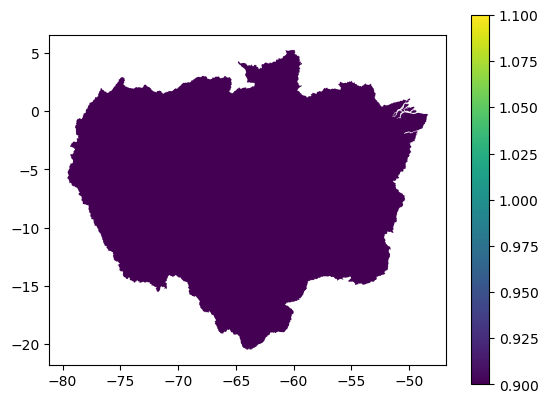

In [4]:
gp_shp = gp.read_file(file_shp)
gp_shp["ID"] = 1
ax0 = gp_shp.plot(column = shp_field, legend = True)

In [5]:
#### FOR REMOVING OCEAN ####
xds_coords = xr.open_dataset(file_coords)
xda_landlake = (xds_coords["LAKEMASK"]  + xds_coords["LANDMASK"])
mask_targetregion = regionmask.mask_geopandas(gp_shp, xds_coords["XLONG"].values.squeeze(), 
                                        xds_coords["XLAT"].values.squeeze(), numbers = shp_field)#.to_numpy()

mask_landlake = (xda_landlake >0).squeeze()
mask_landlake = mask_landlake.rename( {"south_north" : "lat_idx","west_east": "lon_idx"})

mask_targetregion = mask_targetregion.where(np.isfinite(mask_targetregion) & mask_landlake)


In [6]:
# ave_regions = regionmask.mask_geopandas(gp_shp, xda_coords["XLONG"].values, xda_coords["XLAT"].values, numbers = shp_field).to_numpy()

# plt.pcolormesh(lon,lat , ave_regions)
# plt.colorbar()
# plt.show()

# for any other region outside la plata
arr_targetregion = mask_targetregion.to_numpy()
arr_targetregion[np.isnan(arr_targetregion)] = 2  

file_subregions = path.join(path_out, fileout_dat)
with open(file_subregions,"wb") as f:
    f.write(arr_targetregion.astype('float32'))
    f.close 

file_subregions_pkl = path.join(path_out, fileout_pkl)
with open(file_subregions_pkl,'wb') as f:
    pickle.dump(arr_targetregion, f)

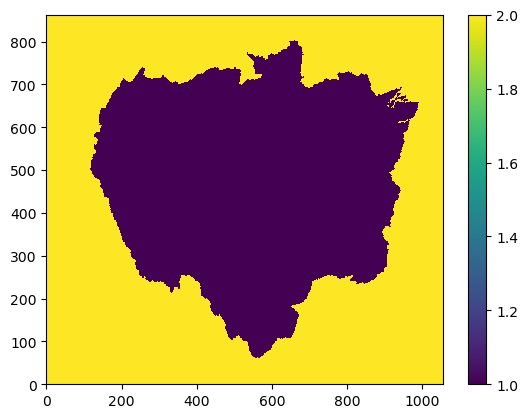

In [7]:
plt.pcolormesh(arr_targetregion)
plt.colorbar()

In [8]:
arr_targetregion.shape

(863, 1055)